In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import gc
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Activation, BatchNormalization, Dropout, LSTM, ConvLSTM2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, LSTM, ConvLSTM2D, Lambda, Reshape, BatchNormalization, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, LearningRateScheduler
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.layers import Lambda, Reshape, DepthwiseConv2D, ZeroPadding2D, Add, MaxPooling2D,Activation, Flatten, Conv2D, Dense, Input, Dropout, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os
from datetime import datetime

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
def get_model():
    
    # Input layer
    img_dims=224
    inputs = Input(shape=(img_dims, img_dims, 3))

    # 1st conv block
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(inputs)
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # 2nd conv block
    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # 3rd conv block
    x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # 4th conv block
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # 5th conv block
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
#     x = AveragePooling2D(pool_size=(4, 4))(x)

    # LSTM layer
    x = Reshape((49, 512))(x)
    x = ((LSTM(512, activation="relu", return_sequences=True, trainable=False)))(x)
    x = BatchNormalization()(x)
#     x = Dropout(0.5)(x)
    
    # FC layer
    x = Flatten(name="flatten")(x)
    x = Dense(units=64, activation='relu')(x)
    x = BatchNormalization()(x)
#     x = Dropout(0.5)(x)

    # Output layer
    output = Dense(units=3, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output)
    opt = RMSprop(lr=0.0001, decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
    
    return model



In [ ]:
model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.save('best_lstm_model.h5') 

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15, fill_mode='nearest')

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
import torch
import torchvision

In [ ]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs,transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name}')
            return images
        self.images={}
        self.class_names=['normal','pneumonia','covid']
        for c in self.class_names:
            self.images[c]=get_images(c)
        self.image_dirs=image_dirs
        self.transform=transform
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    def __getitem__(self, index):
        class_name=random.choice(self.class_names)
        index=index%len(self.images[class_name])
        image_name=self.images[class_name][index]
        image_path =os.path.join(self.image_dirs[class_name], image_name)
        image=Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [ ]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225])
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225])
])

In [ ]:
train_dirs = {
    'normal': '/content/drive/MyDrive/Colab Notebooks/cnn and lstm/Train/NORMAL',
    'covid': '/content/drive/MyDrive/Colab Notebooks/cnn and lstm/Train/COVID',
    'pneumonia':'/content/drive/MyDrive/Colab Notebooks/cnn and lstm/Train/PNEUMONIA'
}
train_dataset=ChestXRayDataset(train_dirs, train_transform)

Found 1200 normal
Found 1045 pneumonia
Found 1200 covid


In [ ]:
test_dirs = {
    'normal': '/content/drive/MyDrive/Colab Notebooks/cnn and lstm/Test/NORMAL',
    'covid': '/content/drive/MyDrive/Colab Notebooks/cnn and lstm/Test/COVID',
    'pneumonia':'/content/drive/MyDrive/Colab Notebooks/cnn and lstm/Test/PNEUMONIA'
}
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 300 normal
Found 300 pneumonia
Found 300 covid


In [ ]:
batch_size=16
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print('Num of training batches', len(dl_train))
print('Num of test batches', len(dl_test))

Num of training batches 216
Num of test batches 57


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import * 
from keras.preprocessing import image
import torch
import torchvision
import os
import random
from PIL import Image

In [ ]:
class_names=train_dataset.class_names
def show_images(images, labels, preds):
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        plt.subplot(4,6,i+1, xticks=[], yticks=[])
        image=image.numpy().transpose((1,2,0))
        mean=np.array([0.485,0.456,0.406])
        std= np.array([0.229, 0.224, 0.225])
        image=image*std/mean
        image=np.clip(image,0.,1.)
        plt.imshow(image)
        col = 'green' if preds[i]==labels[i] else 'red'
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

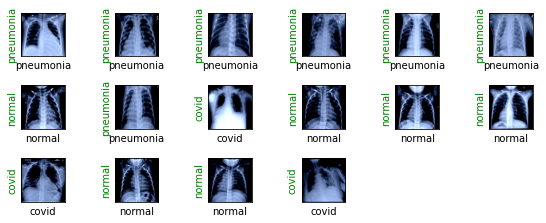

In [ ]:
images, labels =next(iter(dl_train))
show_images(images, labels, labels)

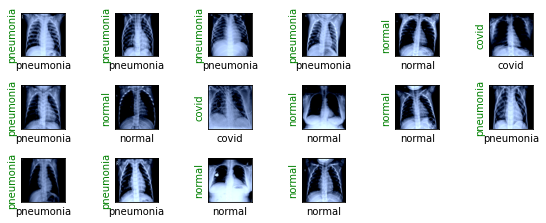

In [ ]:
images, labels =next(iter(dl_test))
show_images(images, labels, labels)

In [ ]:
from math import floor
N_FOLDS = 5
EPOCHS = 50
INIT_LR = 3e-4
T_BS = 16
V_BS = 16
decay_rate = 0.95
decay_step = 1

In [ ]:
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)
log_dir = "./logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [ ]:
callbacks = [ModelCheckpoint(filepath='best_lstm_model.h5', monitor='val_loss',mode='min',verbose=1,save_best_only=True,save_weights_only=True),
             LearningRateScheduler(lambda epoch : INIT_LR * pow(decay_rate, floor(epoch / decay_step))), 
			 tensorboard_callback]

In [ ]:
class_to_label_map = {2 : 'pneumonia', 1 : 'covid', 0 : 'normal'}
submission_predictions = []

In [ ]:
train_generator = train_datagen.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/cnn and lstm/Train",
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=16,
        class_mode="categorical",
        shuffle=True,
        seed=42
    )

Found 3445 images belonging to 3 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/cnn and lstm/Test",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=16,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 900 images belonging to 3 classes.


In [ ]:
#startTrain = time()
history = model.fit_generator(
                generator=train_generator,
                steps_per_epoch=train_generator.n//train_generator.batch_size,
                validation_data=test_generator,
                validation_steps=test_generator.n//test_generator.batch_size,
                epochs=EPOCHS,
                callbacks=callbacks
    )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
215/215 [==============================] - 1019s 5s/step - loss: 0.3541 - accuracy: 0.8772 - val_loss: 4.8102 - val_accuracy: 0.3337

Epoch 00001: val_loss improved from inf to 4.81020, saving model to best_lstm_model.h5
Epoch 2/50
215/215 [==============================] - 62s 286ms/step - loss: 0.2364 - accuracy: 0.9201 - val_loss: 5.2003 - val_accuracy: 0.3337

Epoch 00002: val_loss did not improve from 4.81020
Epoch 3/50
215/215 [==============================] - 63s 293ms/step - loss: 0.1985 - accuracy: 0.9321 - val_loss: 1.5345 - val_accuracy: 0.4643

Epoch 00003: val_loss improved from 4.81020 to 1.53450, saving model to best_lstm_model.h5
Epoch 4/50
215/215 [==============================] - 62s 288ms/step - loss: 0.1714 - accuracy: 0.9431 - val_loss: 0.3599 - val_accuracy: 0.8862

Epoch 00004: val_loss improved from 1.53450 to 0.35988, saving model to best_lstm_model.h5
Epoch 5/50
215/215 [==============================] - 61s 282ms/step - loss: 0.1513 - accuracy: 0

In [ ]:
model.save('best_lstm_model.h5') 

In [ ]:
model.evaluate_generator(train_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.010075926780700684, 0.9988389015197754]

In [ ]:
 test_generator.reset()
 #startTest = time()
 predY=model.predict_generator(
            test_generator,
            steps=test_generator.n//test_generator.batch_size,
            verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


56/56 [==============================] - 4s 68ms/step


In [ ]:
model.evaluate_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.4075482189655304, 0.9177777767181396]

In [ ]:
import numpy as np

a=list(history.history['accuracy'])
b=list(history.history['val_accuracy'])
max_train=100*np.round(max(a),4)
max_validation=100*np.round(max(b),4)

#Finding max of Training accuracy
print("Maximum Training Accuracy is",max_train)

#Finding max  validation accuracy
print("Maximum Validtion Accuracy is",max_validation)

Maximum Training Accuracy is 99.18
Maximum Validtion Accuracy is 92.63


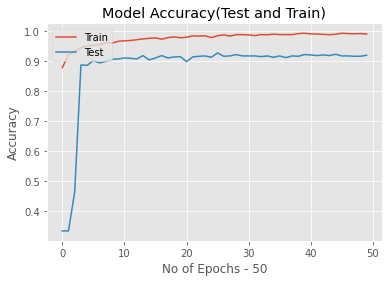

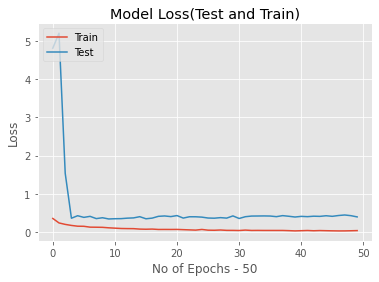

In [ ]:
#Plotting Test vs Train Accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy(Test and Train)')
plt.ylabel('Accuracy')
plt.xlabel('No of Epochs - 50')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Plotting Test vs Train Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss(Test and Train)')
plt.ylabel('Loss')
plt.xlabel('No of Epochs - 50')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()